# Imports

In [1]:
import os
import sys
import json
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# go up until we are in the project base directory
base_dir = os.getcwd()
while base_dir.split('/')[-1] != 'provide':
    base_dir = os.path.normpath(os.path.join(base_dir, '..'))

# add paths for tools and data
things_to_add = ['general_tools', 'aggregation_tools', 'general_data_for_aggregation']
for thing in things_to_add:
    sys.path.append(os.path.join(base_dir, thing))

# import stuff we need
from general_tools import check_if_notebook, mkdir
from oggm_result_filepath_and_realisations import (gcms_mesmer, quantiles_mesmer,
    scenarios_mesmer, oggm_result_dir, provide_regions, raw_oggm_output_file)
from aggregation_preprocessing import open_grid_from_dict
from actual_aggregation import open_files_and_aggregate_on_map, aggregating_scenario, check_slurm_done

In [3]:
# Use this to conditionally execute tests/debugging
if check_if_notebook():
    is_notebook = True
else:
    is_notebook = False

# Define directories

In [4]:
resolution_dir = 'resolution_1_deg'

In [5]:
preprocess_country_dict_outpath = os.path.join(base_dir, 'countries', resolution_dir)
mkdir(preprocess_country_dict_outpath);

# Open data

In [6]:
with open(os.path.join(preprocess_country_dict_outpath, "preprocessed_country_grids.json"), 'r') as f:
    country_structure_dict = json.load(f)

# Code for testing functionalities in notebook

## select test country

In [7]:
if is_notebook:
    test_country_name = 'AUT'
    country_notebook = open_grid_from_dict(country_structure_dict[test_country_name])

## test smoothing and glacier size threshold

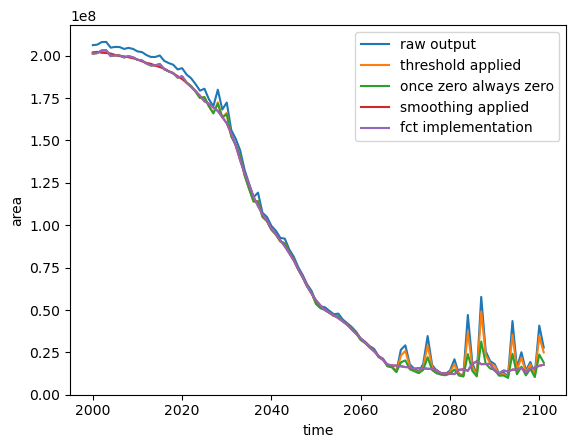

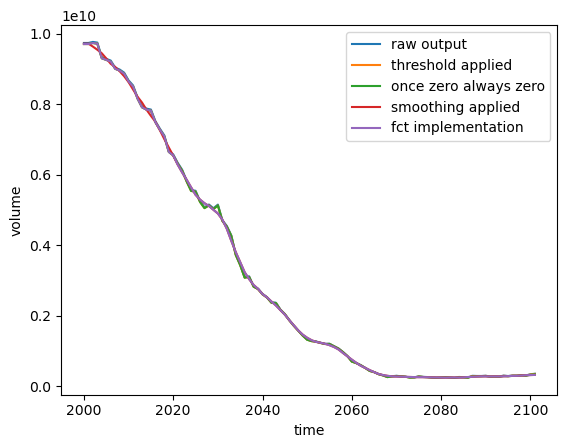

In [8]:
if is_notebook:
    from actual_aggregation import (get_all_files_from_result_batches,
        apply_size_threshold_and_smoothing)
    # get all files for this country, only keep the once from current scenario
    all_files_country = get_all_files_from_result_batches(
        oggm_result_dir,
        raw_oggm_output_file,
        list(country_notebook.result_batches.keys()))

    with xr.open_dataset(all_files_country[0]) as ds:
        ds_example = ds[['volume', 'area']]

    ds_adapted_2 = ds_example.copy()

    # define thersholds
    area_threshold = 0.01 * 1e6  # m²
    # VAS following Marzeion et. al., 2012
    volume_threshold = 0.1912 * area_threshold ** 1.375  # m³

    # use thershold
    ds_adapted_2['volume'] = ds_adapted_2['volume'] - volume_threshold
    ds_adapted_2['area'] = ds_adapted_2['area'] - area_threshold
    below_threshold_mask = (ds_adapted_2.volume < 0) | (ds_adapted_2.area < 0)
    ds_adapted_2['volume'] = xr.where(below_threshold_mask, 0, ds_adapted_2['volume'])
    ds_adapted_2['area'] = xr.where(below_threshold_mask, 0, ds_adapted_2['area'])

    # set everything to zero once a zero occured
    ds_adapted_4 = ds_adapted_2.copy()
    non_zero = ds_adapted_4['volume'] != 0
    mask = non_zero.cumprod('time')
    ds_adapted_4[['volume', 'area']] = ds_adapted_4[['volume', 'area']] * mask
    #ds_adapted_4['volume'] = ds_adapted_4['volume'] * mask
    #ds_adapted_4['area'] = ds_adapted_4['area'] * mask

    # rolling mean
    ds_adapted_3 = ds_adapted_4.copy()
    ds_adapted_3[['area', 'volume']] = ds_adapted_3[['area', 'volume']].rolling(
        min_periods=1, time=5, center=True).mean()

    # area plot
    ds_example.sum(dim='rgi_id').area.plot(label='raw output')
    ds_adapted_2.sum(dim='rgi_id').area.plot(label='threshold applied')
    ds_adapted_4.sum(dim='rgi_id').area.plot(label='once zero always zero')
    ds_adapted_3.sum(dim='rgi_id').area.plot(label='smoothing applied')
    apply_size_threshold_and_smoothing(ds_example.copy()).sum(dim='rgi_id').area.plot(label='fct implementation')
    plt.legend()
    plt.show()

    # volume plot
    ds_example.sum(dim='rgi_id').volume.plot(label='raw output')
    ds_adapted_2.sum(dim='rgi_id').volume.plot(label='threshold applied')
    ds_adapted_4.sum(dim='rgi_id').volume.plot(label='once zero always zero')
    ds_adapted_3.sum(dim='rgi_id').volume.plot(label='smoothing applied')
    apply_size_threshold_and_smoothing(ds_example.copy()).sum(dim='rgi_id').volume.plot(label='fct implementation')
    plt.legend()
    plt.show()

## test aggregation

In [9]:
if is_notebook:
    for test_scenario in scenarios_mesmer[:1]:
        open_files_and_aggregate_on_map(
            target_name=test_country_name,
            target_structure_dict=country_structure_dict,
            scenario=test_scenario,
            output_folder='aggregated_data_test',
            oggm_result_dir=oggm_result_dir,
            raw_oggm_output_file=raw_oggm_output_file,
            intermediate_data_folder=None,
            variables=['volume', 'area', 'thinning_rate', 'runoff'],
            time_steps=np.arange(2015, 2101, 5),
            gcm_test=gcms_mesmer[:1],
            quantile_test=quantiles_mesmer,
            reset_files=True,
        )

Starting openening and aggregation on map for AUT and CurPol
Opening CurPol, ACCESS-ESM1-5, 0.05 (0.0 s)
Files opened, start aggregation on map
saving_map_data
Start total aggregation
Opening CurPol, ACCESS-ESM1-5, 0.25 (1.9 s)
Files opened, start aggregation on map
saving_map_data
Start total aggregation
Opening CurPol, ACCESS-ESM1-5, 0.5 (3.5 s)
Files opened, start aggregation on map
saving_map_data
Start total aggregation
Opening CurPol, ACCESS-ESM1-5, 0.75 (5.1 s)
Files opened, start aggregation on map
saving_map_data
Start total aggregation
Opening CurPol, ACCESS-ESM1-5, 0.95 (6.7 s)
Files opened, start aggregation on map
saving_map_data
Start total aggregation
Finished opening of all raw result files (8.3 s)
Finished openening and aggregation on map for AUT and CurPol


In [10]:
if is_notebook:
    for test_scenario in scenarios_mesmer[:1]:
        aggregating_scenario(
            target_name=test_country_name,
            target_structure_dict=country_structure_dict,
            scenario=test_scenario,
            output_folder='aggregated_data_test',
            oggm_result_dir=oggm_result_dir,
            raw_oggm_output_file=raw_oggm_output_file,
            intermediate_data_folder=None,
            variables=['volume', 'area', 'thinning_rate', 'runoff'],
            risk_variables=['volume', 'area'],
            risk_thresholds=np.append(np.arange(10, 91, 10), [99]),  # in % melted of 2020, 10% means 10% of 2020 melted
            time_steps=np.arange(2015, 2101, 5),
            gcm_test=gcms_mesmer[:1],
            quantile_test=quantiles_mesmer,
            reset_files=True,
        )

Starting aggregation scenario for AUT and CurPol
Calculate runoff reference
  Processing file: 1/3
  Processing file: 2/3
  Processing file: 3/3
Start merging all gcms and raw quantiles and calculate weighted quantiles
Finished opening map files, start calculation of weighted quantiles (0.3 s)


/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/users/pschmitt/mambaforge/envs/oggm_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Finished calculation of weighted quantiles for map (0.9 s)
Finished opening target files, start calculation of weighted quantiles (1.0 s)
Start saving
Finished calculation of weighted quantiles for timeseries (1.3 s)
Finished opening risk files, start calculation of risk (1.4 s)
Finished calculation of weighted quantiles for risk (2.2 s)
Finished aggregation scenario for AUT and CurPol


## look at notebook test results

### map

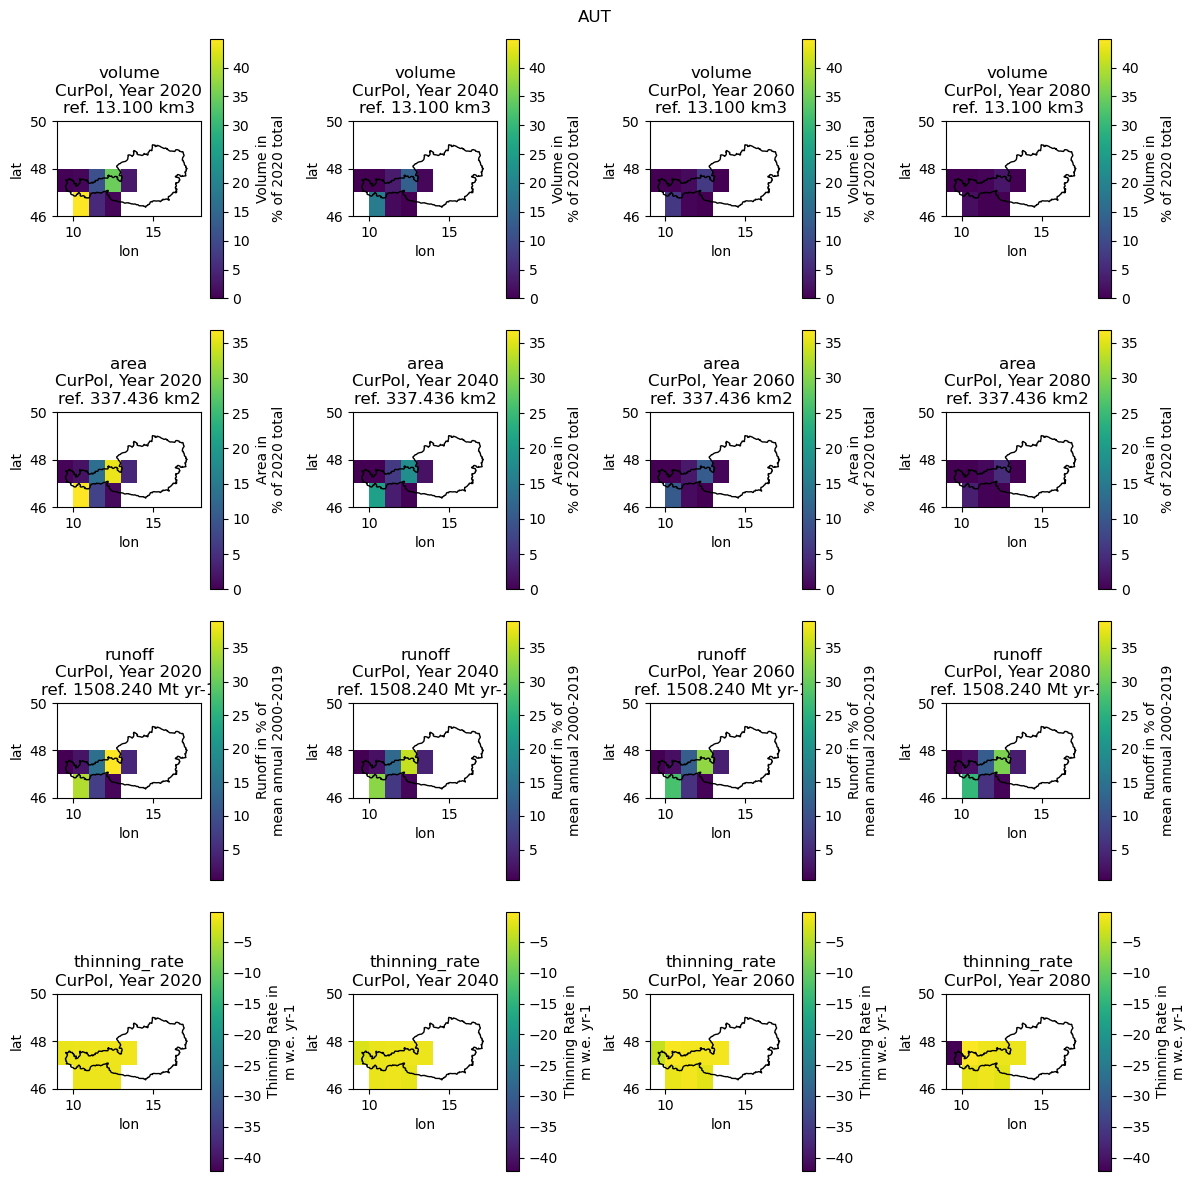

In [11]:
if is_notebook:
    from aggregation_plots import plot_map

    # open shapefile of country for plot
    countries_data_dir = os.path.join(base_dir, 'countries', 'data')
    countries_file = 'ne_10m_admin_0_countries_deu_CA.shp'
    gdf_countries = gpd.read_file(os.path.join(countries_data_dir, countries_file))
    name_col_countries = 'ADM0_A3_DE'
    country = gdf_countries[gdf_countries[name_col_countries] == test_country_name]
    
    plot_map(target=country,
             target_name=test_country_name,
             scenario=scenarios_mesmer[0],
             input_dir='aggregated_data_test',
            )

### total country

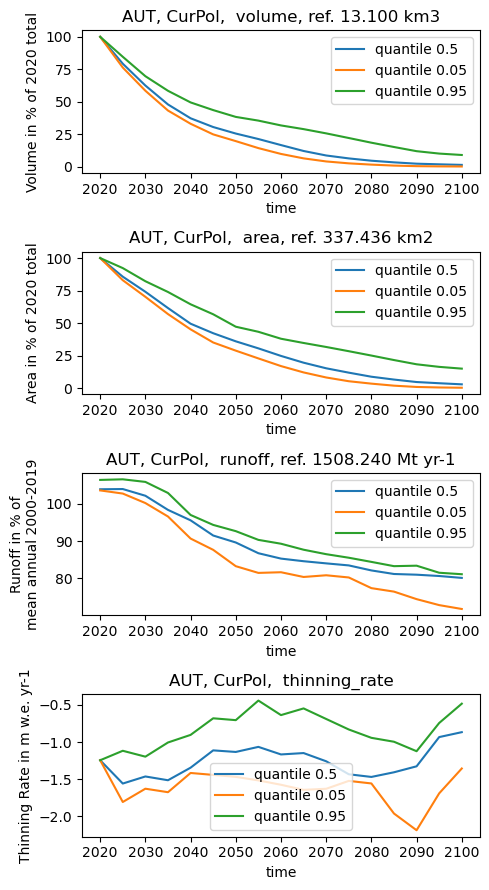

In [12]:
if is_notebook:
    from aggregation_plots import plot_timeseries
    
    plot_timeseries(target_name=test_country_name,
                    scenario=scenarios_mesmer[0],
                    input_dir='aggregated_data_test'
                   )

In [17]:
if is_notebook:
    fp_map = '/home/www/pschmitt/provide/aggregate_data/github/provide/countries/resolution_1_deg/aggregated_data_test/AUT/AUT_CurPol_map.nc'
    fp_total = '/home/www/pschmitt/provide/aggregate_data/github/provide/countries/resolution_1_deg/aggregated_data_test/AUT/AUT_CurPol_timeseries.nc'
    with xr.open_dataset(fp_total) as ds_test:
        ds_test = ds_test

### risk plot

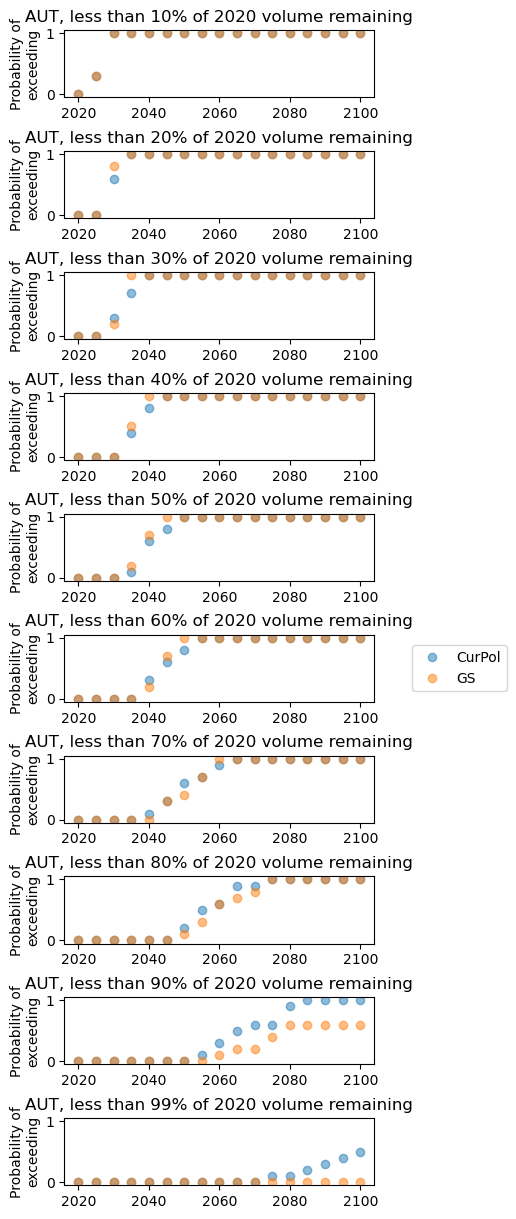

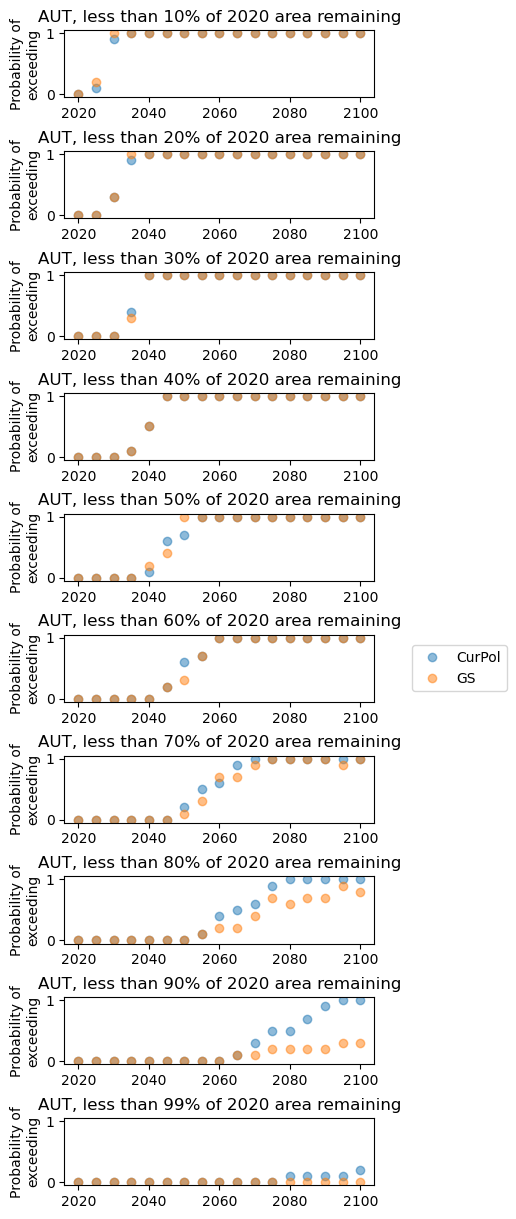

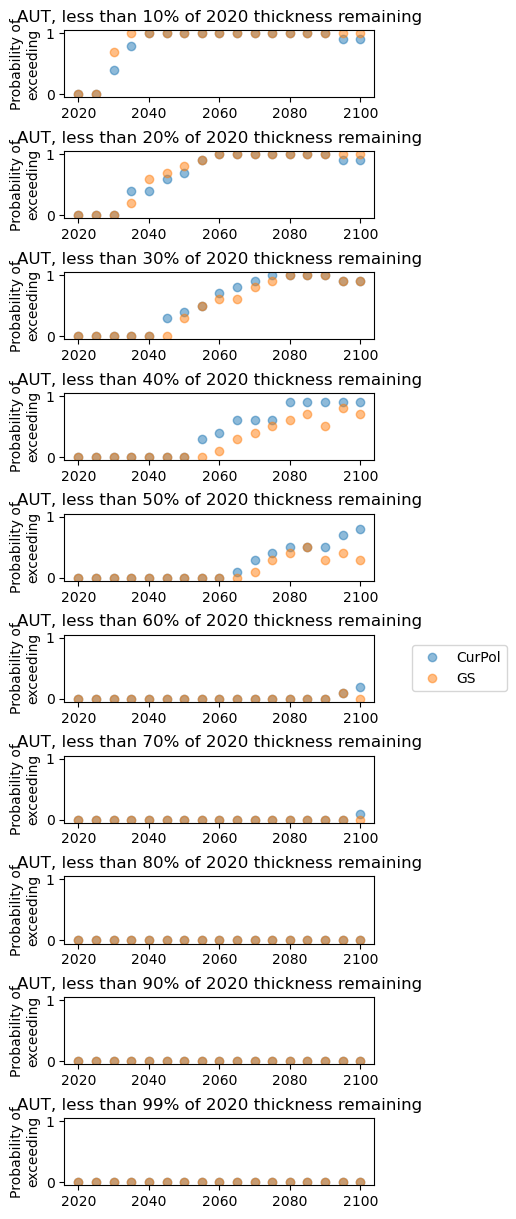

In [12]:
if is_notebook:
    from aggregation_plots import plot_unavoidable_risk
    
    plot_unavoidable_risk(target_name=test_country_name,
                           scenarios=scenarios_mesmer[:2],
                           input_dir='aggregated_data_test')

# Code for running on cluster

## define experiments for multiprocessing

In [15]:
# create dict for sbatch --array=
slurm_arrays = {}

count = 1
for country in country_structure_dict.keys():
    for scenario in scenarios_mesmer:
        slurm_arrays[str(count)] = (country, scenario)
        count += 1

if is_notebook:
    print(slurm_arrays)

{'1': ('CHL', 'CurPol'), '2': ('CHL', 'GS'), '3': ('CHL', 'LD'), '4': ('CHL', 'ModAct'), '5': ('CHL', 'Ref'), '6': ('CHL', 'Ren'), '7': ('CHL', 'Neg'), '8': ('CHL', 'SP'), '9': ('CHL', 'ssp119'), '10': ('CHL', 'ssp534-over'), '11': ('CHN', 'CurPol'), '12': ('CHN', 'GS'), '13': ('CHN', 'LD'), '14': ('CHN', 'ModAct'), '15': ('CHN', 'Ref'), '16': ('CHN', 'Ren'), '17': ('CHN', 'Neg'), '18': ('CHN', 'SP'), '19': ('CHN', 'ssp119'), '20': ('CHN', 'ssp534-over'), '21': ('DEU', 'CurPol'), '22': ('DEU', 'GS'), '23': ('DEU', 'LD'), '24': ('DEU', 'ModAct'), '25': ('DEU', 'Ref'), '26': ('DEU', 'Ren'), '27': ('DEU', 'Neg'), '28': ('DEU', 'SP'), '29': ('DEU', 'ssp119'), '30': ('DEU', 'ssp534-over'), '31': ('NPL', 'CurPol'), '32': ('NPL', 'GS'), '33': ('NPL', 'LD'), '34': ('NPL', 'ModAct'), '35': ('NPL', 'Ref'), '36': ('NPL', 'Ren'), '37': ('NPL', 'Neg'), '38': ('NPL', 'SP'), '39': ('NPL', 'ssp119'), '40': ('NPL', 'ssp534-over'), '41': ('UZB', 'CurPol'), '42': ('UZB', 'GS'), '43': ('UZB', 'LD'), '44':

## run current experiment

In [ ]:
if not is_notebook:
    slurm_id = os.environ.get('ARRAY_ID', None)
    # convert slurm array to region and scenario
    country, scenario = slurm_arrays[slurm_id]

    # save results on cluster and copy at the end in run_slurm-file
    working_dir_cluster = os.environ.get('OGGM_WORKDIR', None)

    aggregated_data_outpath = os.path.join(
        working_dir_cluster, 'aggregated_data')
    mkdir(aggregated_data_outpath);

    aggregated_data_intermediate_outpath = os.path.join(
        working_dir_cluster, 'aggregated_data_intermediate')
    mkdir(aggregated_data_intermediate_outpath);

    open_files_and_aggregate_on_map(
            target_name=country,
            target_structure_dict=country_structure_dict,
            scenario=scenario,
            output_folder=aggregated_data_outpath,
            oggm_result_dir=oggm_result_dir,
            raw_oggm_output_file=raw_oggm_output_file,
            intermediate_data_folder=aggregated_data_intermediate_outpath,
            variables=['volume', 'area', 'thinning_rate', 'runoff'],
            #risk_variables=['volume', 'area'],
            #risk_thresholds=np.append(np.arange(10, 91, 10), [99]),  # in % melted of 2020, 10% means 10% of 2020 melted
            time_steps=np.arange(2015, 2101, 5),
            reset_files=False
        )

## check which experiments failed for rerunning

In [5]:
if is_notebook:
    check_slurm_done(461331)

All files contain 'SLURM DONE'.


In [12]:
if is_notebook:
    check_slurm_done(435463)

All files contain 'SLURM DONE'.
